In [ ]:
# Python packages
import scanpy as sc
import anndata as ad
import scvi

import scib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.neighbors import NearestNeighbors, KDTree
from matplotlib.colors import ListedColormap
import typing as tp
import squidpy as sq
import seaborn as sns
import csv
import gzip
import os
import scipy.io
import cosg as cos
import bbknn
from scib_metrics.benchmark import Benchmarker


## import functions for KNN reannoation 
from functions import *


In [3]:
palette= {'Astrocytes': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'Endothelial': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 'Excitatory_Neurons': (1.0, 0.4980392156862745, 0.054901960784313725),
 'Inhibitory_Neurons': (1.0, 0.7333333333333333, 0.47058823529411764),
 'Macro': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'Microglia': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 'Monocytes': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'Lymphocytes': (1.0, 0.596078431372549, 0.5882352941176471),
 'OPC': (0.5, 0, 0.5),
 'Oligodendrocytes': (0.7725490196078432,
  0.6901960784313725,
  0.8352941176470589),
 'Pericytes': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'T_Cells': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 'xenium': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'VLMC': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 'unknown': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 'singelCell':  (0.0, 0.0, 1.0),
 'Tumor': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 'AC_like': (0.8549019607843137, 0.6470588235294118, 0.12549019607843137),
 'G1_S1': (0.803921568627451, 0.5215686274509804, 0.24705882352941178),
 'G2_M1': (0.9568627450980393, 0.6431372549019608, 0.3764705882352941),
 'MES1_like': (0.803921568627451, 0.3607843137254902, 0.3607843137254902),
 'MES2_like': (0.5019607843137255, 0.0, 0.0),
 'NPC1_like': (0.2549019607843137, 0.4117647058823529, 0.8823529411764706),
 'NPC2_like': (0.39215686274509803, 0.5843137254901961, 0.9294117647058824),
 'OPC_like': (0.0, 0.39215686274509803, 0.0),
 'non_neoplastic': (0.8274509803921568, 0.8274509803921568, 0.8274509803921568)
         }

## Prepare data


For this analysis, pre-processed single-cell transcriptomic data with predefined cell labels (annot_v1) is required. 
The data type is specified in the observation variable 'Method'. The pre-processed snRNA data is loaded into Scanpy as adata_sn as follows:

In [ ]:
# load snRNA data
# annotation saved under 'annot_v1'
adata_sn = sc.read_h5ad(
    filename="sn_data.h5ad")

adata_sn.obs["Method"] = 'singelCell'
adata_sn.layers['counts'] = adata_sn.raw.X.copy()
adata_sn.layers['lognorm'] = adata_sn.X.copy()

Same as for the snRNA data, a pre-processed spatial transcriptomic data (Xenium) is necessary. However, for the Xenium data a predefined annotation is not needed. 
To ensure a succsessful merging the observation variables 'Method' and 'annot_v1' also have to be present in the Xenium data.

In [5]:
# Load merged Xenium data
adata_xenium=sc.read_h5ad(filename="xenium_data.h5ad")
adata_xenium.obs.rename(columns={"sample": "orig.ident"}, inplace=True)
adata_xenium.obs["Method"] = 'xenium'
adata_xenium.obs["annot_v1"] = 'unknown'


## Data Integration 

At this point, the two datasets are merged without applying any batch corrections. To ensure proper integration, the gene set in the snRNA data are restricted to those included in the Xenium panel (by setting the merge = 'only in ad.concat())

In [ ]:
adata = ad.concat([adata_sn,adata_xenium], merge="only")
sc.pp.scale(adata, max_value=10)
print("Computing PCA...")
sc.pp.pca(adata)
print("Generating a kNN graph...")
sc.pp.neighbors(adata)
print("Calculating UMAP...")
sc.tl.umap(adata)
print("Defining clusters...")
sc.tl.leiden(adata)



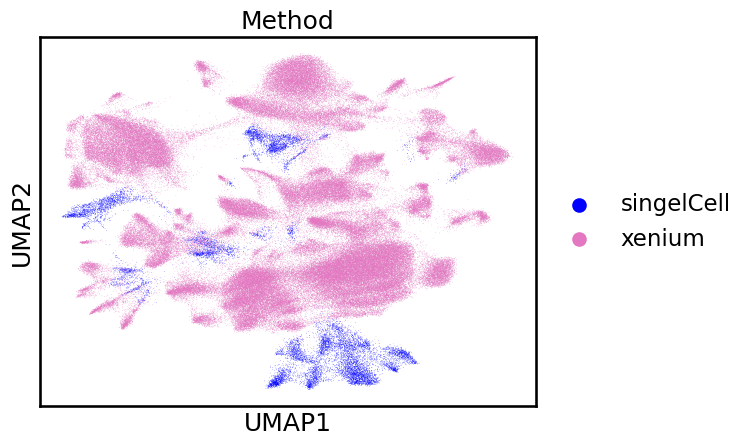

In [7]:
sc.pl.umap(adata, color=['Method'], palette=palette)

## Batch-aware feature selection

To reduce noise a subset of genes is used for the analysis.The gene selection must be batch-aware, this can be achieved by setting the batch_key argument in the scanpy.highly_variable_genes() function.

In [8]:
batch_key='Method'
label_key='annot_v1'

sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor="cell_ranger", batch_key=batch_key
)


adata_hvg = adata[:, adata.var["highly_variable"]].copy()

## ScVi - Integrating Data
 

### Data Preparation 

In [9]:
adata_scvi = adata_hvg.copy()
scvi.model.SCVI.setup_anndata(adata_scvi, layer="counts", batch_key=batch_key)
adata_scvi


AnnData object with n_obs × n_vars = 200893 × 262
    obs: 'orig.ident', 'annot_v1', 'Method', 'leiden', '_scvi_batch', '_scvi_labels'
    var: 'features', 'gene_ids', 'n_cells', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'Method_colors', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'lognorm'
    obsp: 'distances', 'connectivities'

### Building the model

In [10]:
model_scvi = scvi.model.SCVI(adata_scvi)
model_scvi

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

### Training the model
By default, scVI sets 400 epochs for datasets under 20,000 cells, and gradually reduces the epochs as cell count increases. This ensures the network learns the same amount from fewer epochs as more cells are processed per iteration.

In [11]:
max_epochs_scvi = np.min([round((20000 / adata_hvg.n_obs) * 400), 400])
max_epochs_scvi

40

In [ ]:
model_scvi.train()

In [13]:
adata_scvi.obsm["X_scVI"] = model_scvi.get_latent_representation()
sc.pp.neighbors(adata_scvi, use_rep="X_scVI")
sc.tl.leiden(adata_scvi,resolution=1.5, key_added='leiden_scvi')
sc.tl.umap(adata_scvi)


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [14]:
adata_scvi.write_h5ad('adata_scvi.h5ad')

### Plot Results

snRNA data before integration

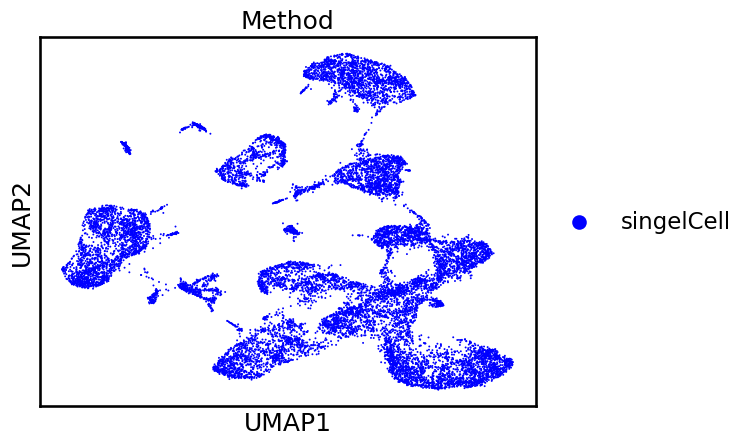

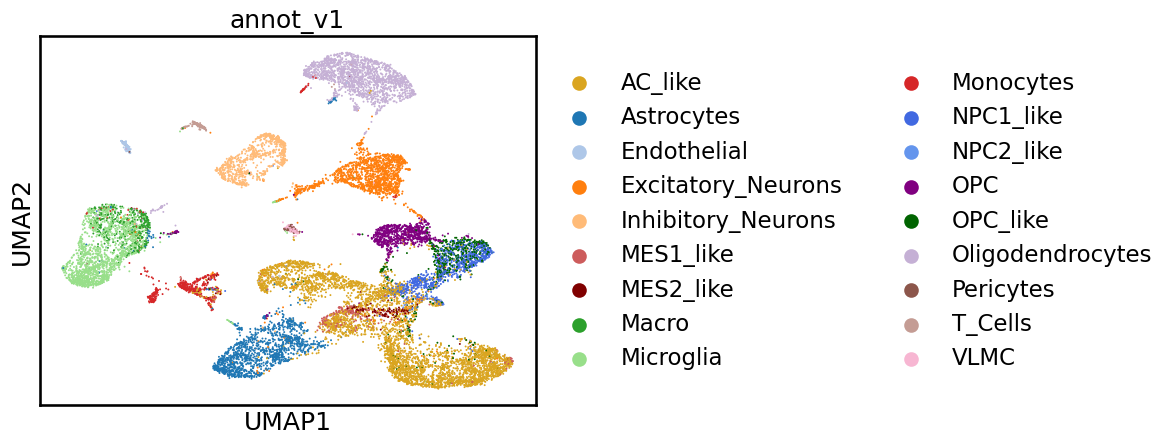

In [15]:
sc.pl.umap(adata_sn, color=[batch_key], wspace=1, palette=palette)
sc.pl.umap(adata_sn, color=[label_key], wspace=1, palette=palette)

Xenium data before integration

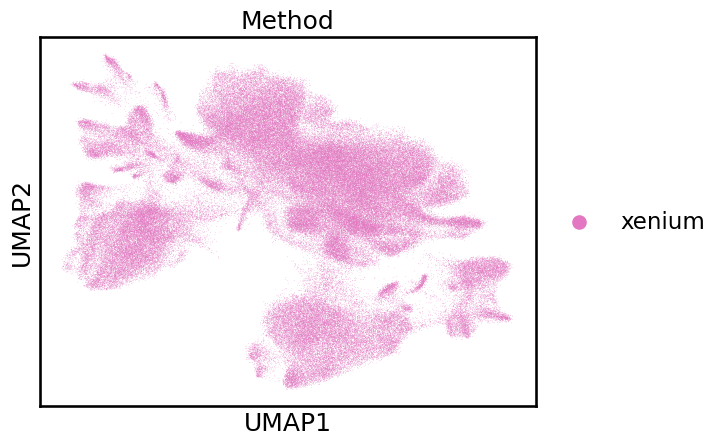

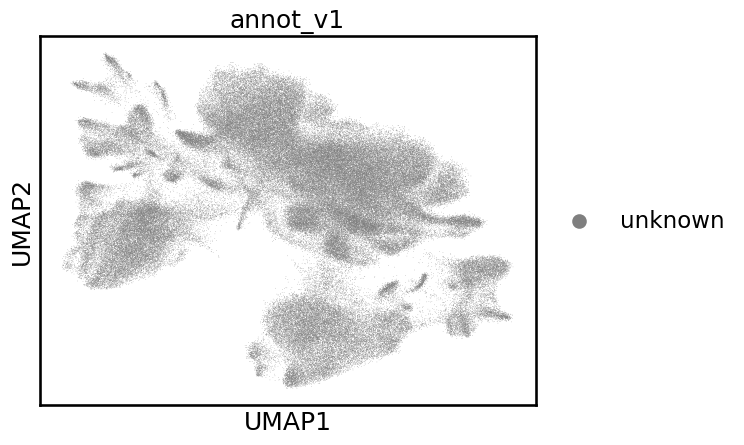

In [16]:
sc.pl.umap(adata_xenium, color=[batch_key], wspace=1, palette=palette)
sc.pl.umap(adata_xenium, color=[label_key], wspace=1, palette=palette)

snRNA and xenium data after scVi integration

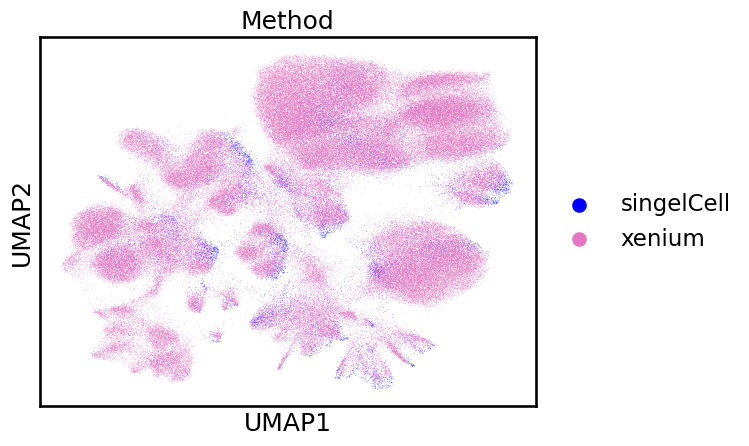

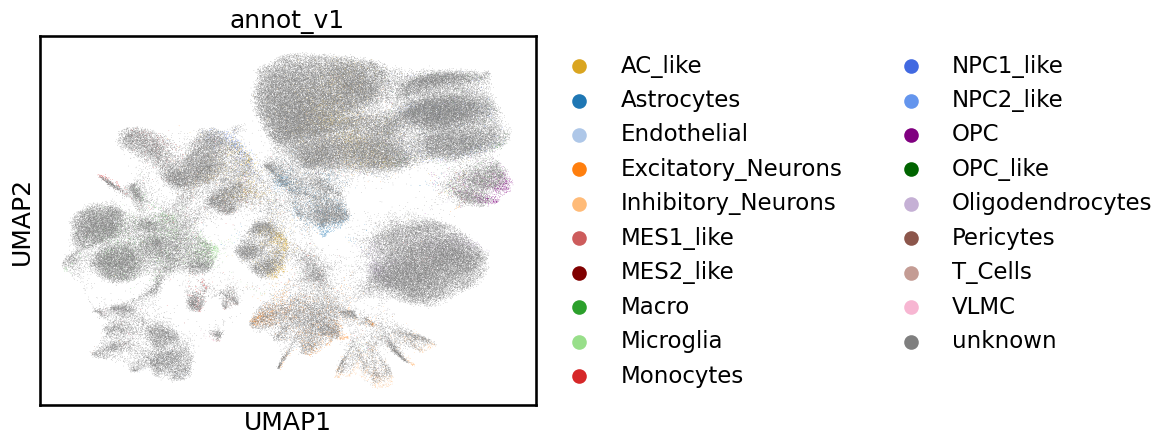

In [17]:
sc.pl.umap(adata_scvi, color=[batch_key], wspace=1, palette=palette)
sc.pl.umap(adata_scvi, color=[label_key], wspace=1, palette=palette)

## KNN - Re-annotation

After running scVi, we use the k-nearest neighbors (KNN) method to assign cell labels to the Xenium data based on the 20 nearest snRNA neighbors (k=20).

In [ ]:
adata_final=reannotation_KNN(adata_scvi)
sc.pl.umap(adata_final, color=['annot_v1'],palette=palette )

Control if cells from both methods are present in every cluster 

/tmp/ipykernel_21402/2891145462.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  annot_v1=adata_final.obs.groupby('leiden_scvi')['annot_v1'] \


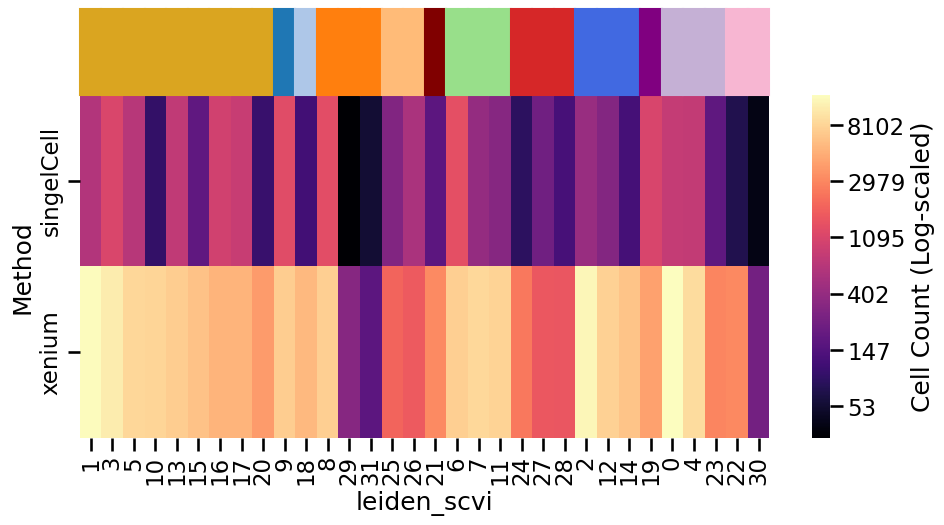

In [23]:
# cell amount in Leiden cluster for every method 
cluster_counts = adata_final.obs.groupby(['leiden_scvi', 'Method'], observed=False).size().unstack(fill_value=0)

# determine log-scaled values
log_counts =np.log1p(cluster_counts)

# adding Information about cell type
annot_v1=adata_final.obs.groupby('leiden_scvi')['annot_v1'] \
                                 .apply(lambda x: x.value_counts().idxmax())
log_counts['annot_v1'] = annot_v1
log_counts = log_counts.sort_values(['annot_v1', 'leiden_scvi'])
log_counts_sorted = log_counts.drop(columns='annot_v1').T



annot_row = pd.DataFrame({
    'Method': log_counts_sorted.index
}, index=log_counts_sorted.index)

annot_col = pd.DataFrame({
    'Cell Type': log_counts['annot_v1']
}, index=log_counts.index)





plt.figure(figsize=(10, 6))
# Create the heatmap with log-transformed values
sns.heatmap(log_counts_sorted, cmap="magma", cbar_kws={'label': 'Cell Count (Log-scaled)'}, xticklabels=True)


# Customize colorbar to show non-log-transformed values
colorbar = plt.gca().collections[0].colorbar
ticks = colorbar.get_ticks()[1:-1]
colorbar.set_ticks(ticks)  
colorbar.set_ticklabels([int(np.expm1(t)) for t in ticks]) 


# add color palette
for idx, cell_type in enumerate(annot_col['Cell Type']):
    plt.gca().add_patch(plt.Rectangle((idx, -0.5), 1, 0.5, color=palette[cell_type], clip_on=False))

# Adjust plot to fit annotations
plt.subplots_adjust(top=0.95)
plt.tight_layout()




Now we kann map the cell labels backon the xenium data

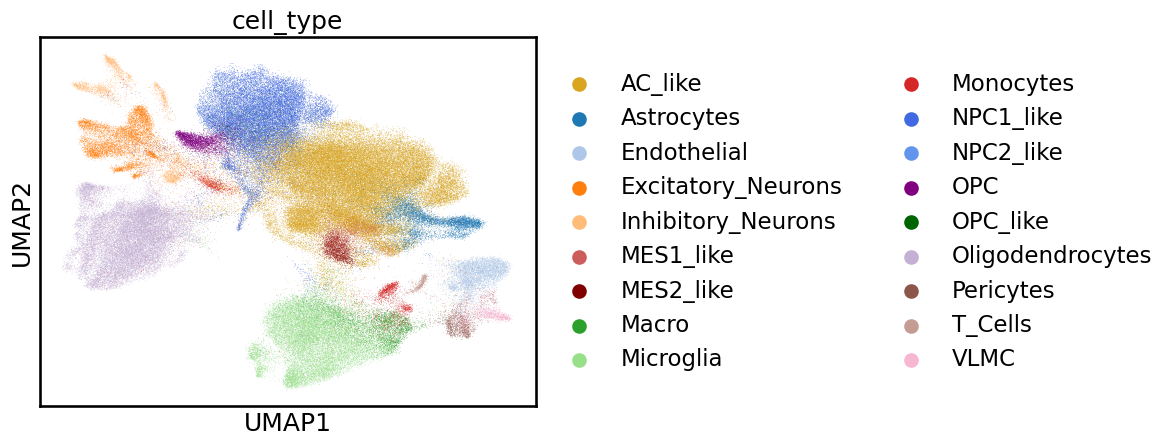

In [20]:
annotations = adata_final.obs['annot_v1']
mapped_values = adata_xenium.obs.index.map(annotations)
adata_xenium.obs['cell_type'] = mapped_values
sc.pl.umap(adata_xenium, color=['cell_type'], palette=palette)

**finished identifying marker genes by COSG**


/tmp/ipykernel_21402/1469274973.py:138: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/tmp/ipykernel_21402/1469274973.py:138: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/tmp/ipykernel_21402/1469274973.py:138: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/

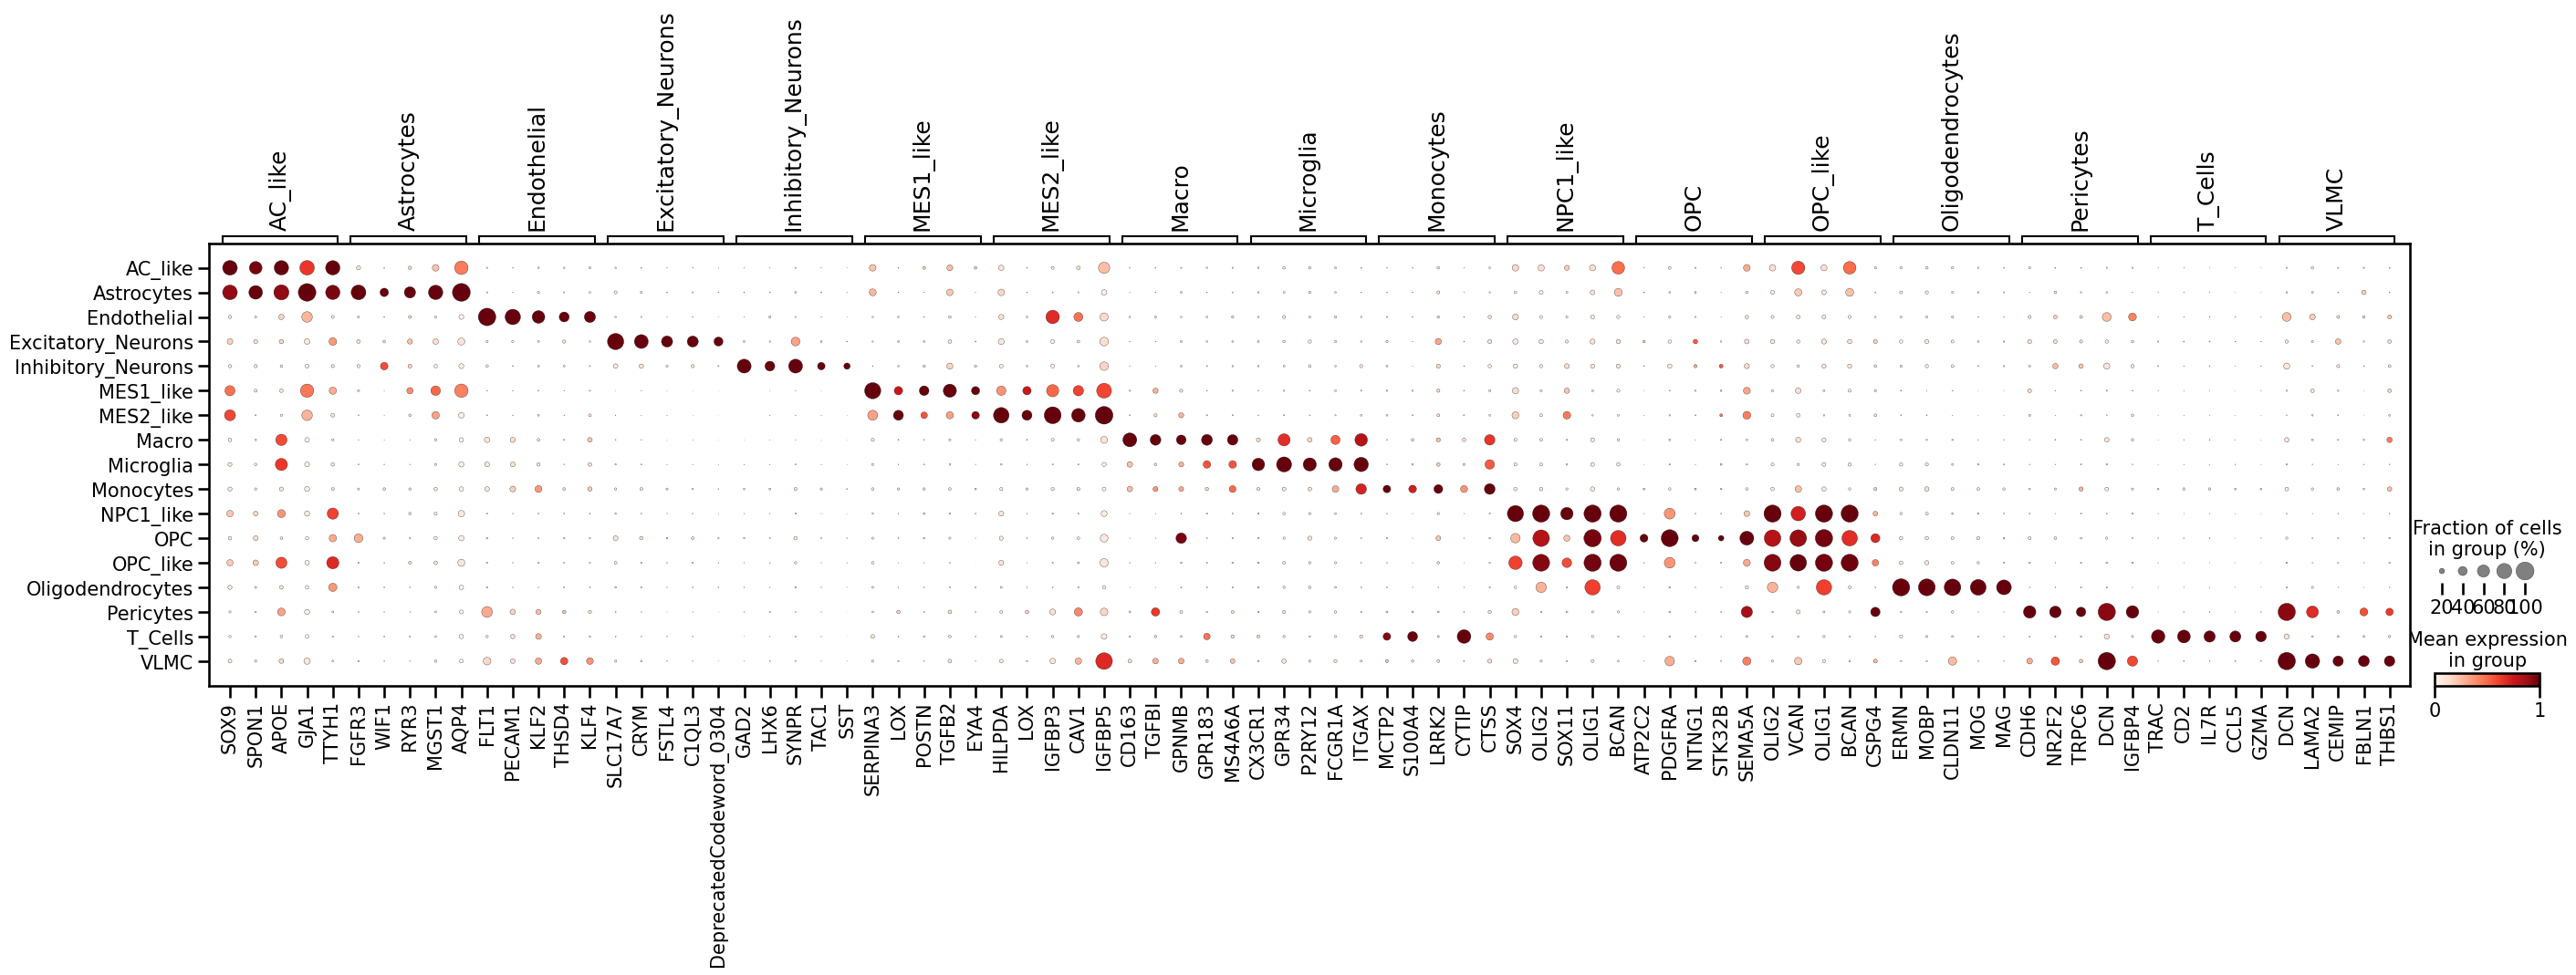

In [24]:

import cosg as cosg
cosg.cosg(adata_xenium, key_added='cosg', groupby='cell_type')
rank_genes_groups_dotplot(
    adata_xenium,
    groupby='cell_type',  # use your own annotation column 
    n_genes=5,  # plot 5 markers per cell type (adjust as needed)
    key="cosg",
    dendrogram=False,
     standard_scale="var")
    
